In [23]:
# initialize packages
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [24]:
# Load data showing Daily total female births in California, 1959
# Data source: https://www.kaggle.com/datasets/dougcresswell/daily-total-female-births-in-california-1959
df = pd.read_csv("data_1.csv")
print("Our data shape is: {}".format(df.shape))
df.head()

Our data shape is: (365, 2)


,Date,Births
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


In [25]:
# Some simple column editing
df.rename({'Date':'date', 'Births':'y'}, axis='columns', inplace=True)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['date'] = df['date'].dt.date 
df.head()

,date,y
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


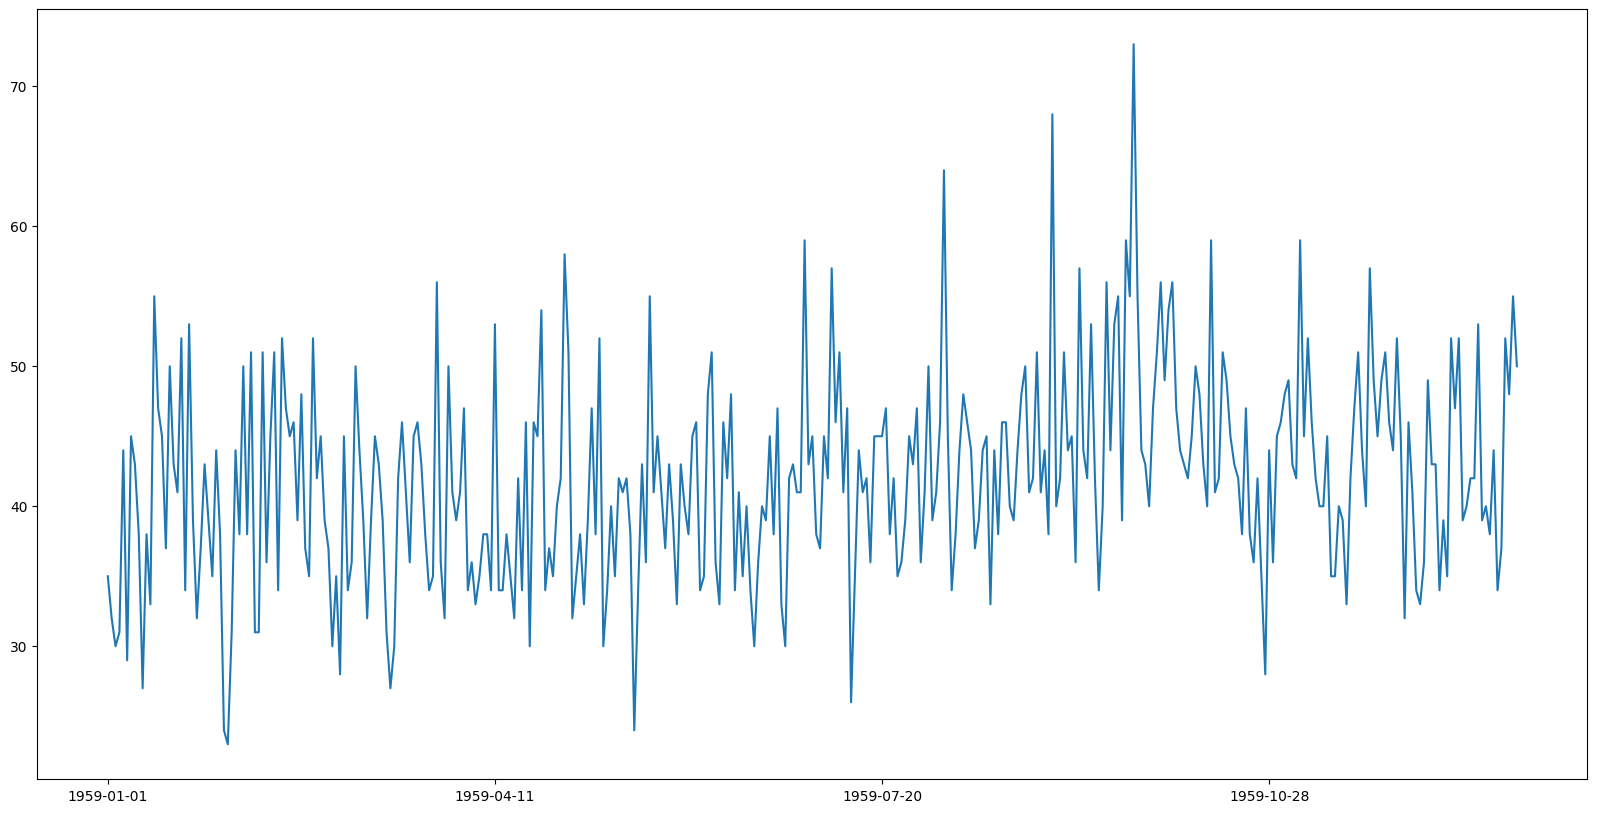

In [26]:
#plot data
# plots 
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(nrows=1, ncols=1)

ax0 = fig.add_subplot(gs[0, :])

ax0.plot(df.y)
ax0.set_xticks(np.arange(0,len(df.y),100))                                                       # display every 10-th tick
ax0.set_xticklabels(df.date[np.arange(0,len(df.y),100)],rotation=0);  

Check if the series is stationary with AC&PAC functions and by means of statistical tests.

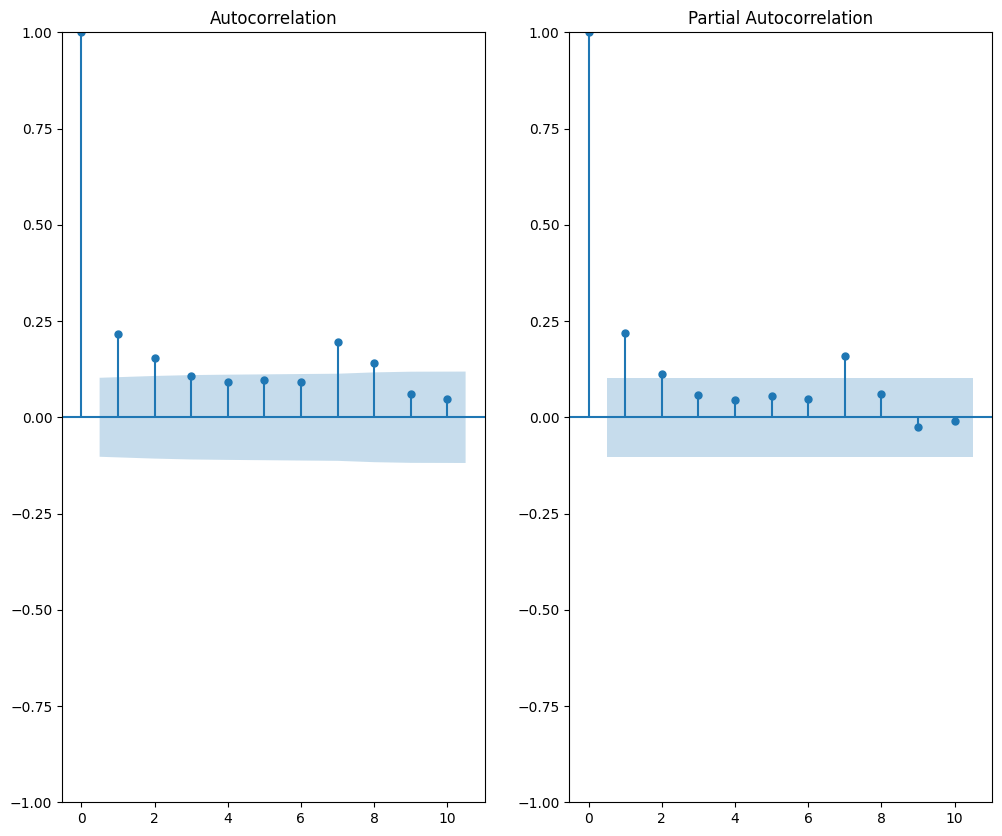

In [27]:
# Inspect AC and PAC functions. 
fig, axs = plt.subplots(1, 2,figsize=(12,10))
sm.graphics.tsa.plot_acf(df.y, lags=10, ax=axs[0]);
sm.graphics.tsa.plot_pacf(df.y, lags=10, ax=axs[1]);


# Inspect AC
# If the time series is stationary, the ACF should decay exponentially i.e. decline to near zero rapidly or exhibit a sinusoidal pattern as the lag increases. 
# If the ACF decays more slowly or exhibits more complex behavior as the lag increases, it may suggest that the time series is non-stationary.
# I would say the AC function plot suggests the series is stationary since it declines quickly.


# Inspect PAC
# The PACF decays quickly as well. It suggests that the time series is non-stationary.

In [28]:
# Test the data for stationarity by using augmented Dickey-Fuller and Kwiatkowski-Phillips-Schmidt-Shin test.
# Augmented Dickey-Fuller (ADF) test

# Null hypothesis in ADF-test: the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure).
# Alternate hypothesis in ADF-test: the time series is stationary.
print("Results of Dickey-Fuller Test:")
res = sm.tsa.stattools.adfuller(df.y, maxlag=5,regression='c',autolag='AIC')
print(f"Test Statistic:{res[0]}")
print(f"p-value:{res[1]}")
print(f"#Lags Used:{res[2]}")
print(f"#Observations Used:{res[3]}")
print(f"#Critical value:{res[4]}")

print("\n-----------------------------------------------------------------------------------------------------------")
print("DECISION RULE: If p-value is < than desired significance level (5%) we reject the null hypothesis.\n")
if res[1] < 0.05:
    print("Since the p-value is less than the significance level (5%), we reject the null hypothesis that the timeseries is not stationary." +
          "\nConclusion The time series is stationary.")
else:
    print("Since the p-value is greater than the significance level (5%), we accept the null hypothesis that the timeseries is not stationary.")

Results of Dickey-Fuller Test:
Test Statistic:-10.588086912092177
p-value:6.636284469516517e-19
#Lags Used:1
#Observations Used:363
#Critical value:{'1%': -3.448493650810824, '5%': -2.8695352280356556, '10%': -2.5710293341377715}

-----------------------------------------------------------------------------------------------------------
DECISION RULE: If p-value is < than desired significance level (5%) we reject the null hypothesis.

Since the p-value is less than the significance level (5%), we reject the null hypothesis that the timeseries is not stationary.
Conclusion The time series is stationary.


In [29]:
# Kwiatkowski-Phillips-Schmidt-Shin(KPSS) test
# Null hypothesis in KPSS-test: the time series data is stationary.
# alternate hypothesis: the time series data is non-stationary.
print("Results of KPSS Test:")
res = sm.tsa.stattools.kpss(df.y,regression='c',nlags='auto')
print(f"Test Statistic:{res[0]}")
print(f"p-value:{res[1]}")
print(f"#truncation lags:{res[2]}")
print(f"#Critical value:{res[3]}")

print("\n-----------------------------------------------------------------------------------------------------------")
print("DECISION RULE: If p-value is < than desired significance level (5%) we reject the null hypothesis.\n")

if res[1] < 0.05:
    print("Since the p-value is less than the significance level (5%), we reject the null hypothesis that the timeseries is stationary." +
          "\nConclusion The time series is non-stationary.")
else:
    print("Since the p-value is greater than the significance level (5%), we accept the null hypothesis that the timeseries is stationary.")

Results of KPSS Test:
Test Statistic:1.6129657593856863
p-value:0.01
#truncation lags:7
#Critical value:{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

-----------------------------------------------------------------------------------------------------------
DECISION RULE: If p-value is < than desired significance level (5%) we reject the null hypothesis.

Since the p-value is less than the significance level (5%), we reject the null hypothesis that the timeseries is stationary.
Conclusion The time series is non-stationary.


After analyzing the ACF and PACF in conjunction with the carrying out the following statistical tests; Augmented Dickey-Fuller (ADF) and Kwiatkowski-Phillips-Schmidt-Shin(KPSS) tests, It seems I cannot confidently label the data as a stationary timeseries. I will have to then transform it so it can be rendered as stationary. We have to do this because if we fit an ARIMA model to a non-stationary time series, the model's predictions may not be accurate. This is because the ARIMA model is designed to capture patterns in the data that are stable over time, and these patterns may not be present in a non-stationary time series. As a result, the model's forecasts may be poor.

To render the series stationary and ready for modelling; I will use the Differencing method. This involves taking the difference between consecutive observations in the time series. This can be effective in removing trends and seasonality from the time series.


In [30]:
# To make the time series stationary, I will difference the data
#y = np.asarray(df['y'].diff().combine_first(df.y))
Y = np.asarray(df.y)
y = (100*(Y[1:Y.size]/Y[0:Y.size-1]-1))

In [31]:
# I will repeat the whole process to test if the new differenced series is stationary or not
print("Results of Dickey-Fuller Test:")
res = sm.tsa.stattools.adfuller(y, maxlag=5,regression='c',autolag='AIC')
print(f"Test Statistic:{res[0]}")
print(f"p-value:{res[1]}")
print(f"#Lags Used:{res[2]}")
print(f"#Observations Used:{res[3]}")
print(f"#Critical value:{res[4]}")

print("\nResults of KPSS Test:")
res = sm.tsa.stattools.kpss(y,regression='c',nlags='auto')
print(f"Test Statistic:{res[0]}")
print(f"p-value:{res[1]}")
print(f"#truncation lags:{res[2]}")
print(f"#Critical value:{res[3]}")

Results of Dickey-Fuller Test:
Test Statistic:-12.374610597248205
p-value:5.189201938629897e-23
#Lags Used:5
#Observations Used:358
#Critical value:{'1%': -3.448748905151901, '5%': -2.8696473721448728, '10%': -2.5710891239349585}

Results of KPSS Test:
Test Statistic:0.36103604845062137
p-value:0.09394997911611147
#truncation lags:51
#Critical value:{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


Analysis of the result for the newly differenced series y0

For Dickey-Fuller Test, since the p-value is less than the significane level (5%), we reject the null hypothesis that the timeseries is not stationary.

For the KPSS Test, since the p value is greater than the desired significance level (5%), we accept the null hypothesis that the time series is stationary.

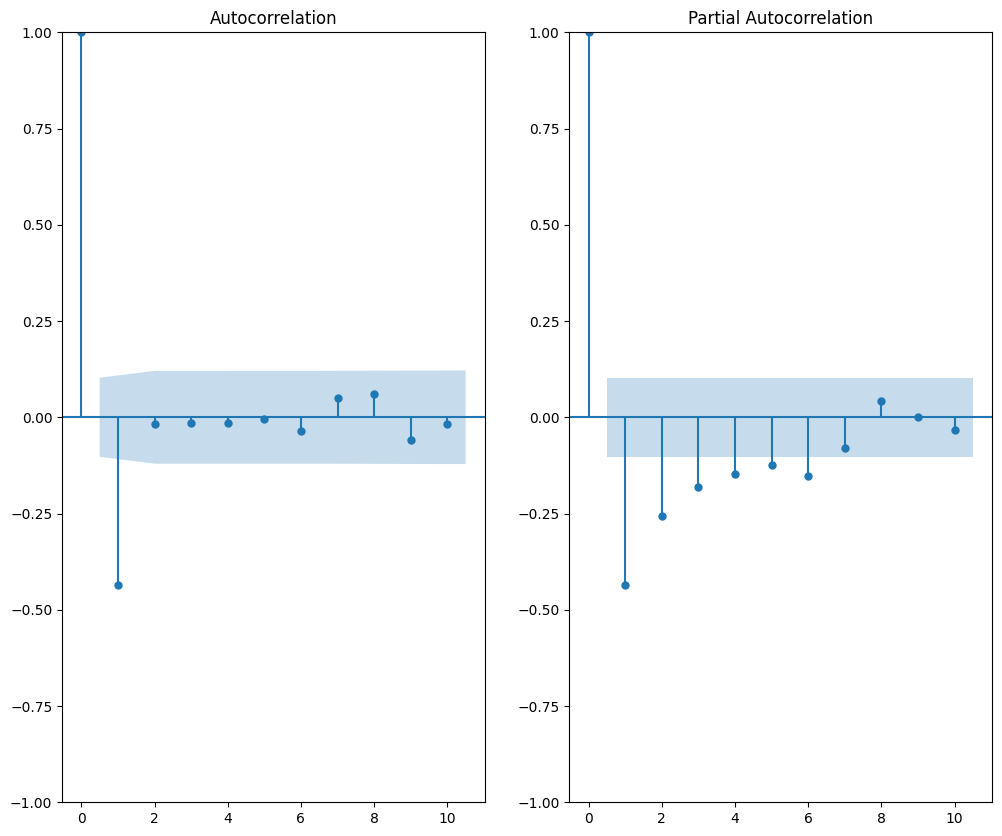

In [32]:
# Inspect AC and PAC functions. 
fig, axs = plt.subplots(1, 2,figsize=(12,10))
sm.graphics.tsa.plot_acf(y, lags=10, ax=axs[0]);
sm.graphics.tsa.plot_pacf(y, lags=10, ax=axs[1]);

# The time series y is stationary since the ACF and PACF decay exponentially i.e. decline to near zero rapidly

Take stationary series (from step 1), reserve the first 80% of the sample for estimation and select an appropriate ARIMA model

In [33]:
# reserve first 80%
y_estimation = y[0:round(0.8*len(y))]
y_test = y[round(0.8*len(y)):]

print("Size of y for estimation: {0}".format(len(y_estimation)))
print("Size of y for test: {0}".format(len(y_test)))

Size of y for estimation: 291
Size of y for test: 73


In [34]:
import warnings
warnings.filterwarnings("ignore") 

# Select appropraite ARIMA model
# estimate ICs
IC = sm.tsa.stattools.arma_order_select_ic(y_estimation, max_ar=4, max_ma=4, ic=['aic','bic','hqic'], trend='c')

# display optimal lags
print(f"min AIC at (p,q): {IC.aic_min_order}")
print(f"min BIC at (p,q): {IC.bic_min_order}")
print(f"min HQIC at (p,q): {IC.hqic_min_order}")

# Use the Akaike Information Criterion (AIC) or the Bayesian Information Criterion (BIC) to select the best fitting model from a set of models with different orders. 
# These criteria would help us to select the model that strikes a balance between goodness of fit and parsimony (simplicity).

# ICs suggest AR(2, 0, 3) or AR(0, 0, 1)

min AIC at (p,q): (2, 3)
min BIC at (p,q): (0, 1)
min HQIC at (p,q): (2, 3)


In [35]:
mod = sm.tsa.arima.ARIMA(y_estimation, order=(2, 0, 3), trend='c', validate_specification=True)
res = mod.fit()
print(res.summary())

# --Interpret statistical significance of the coefficients.
# Null Hypothesis is that each coefficient is NOT statistically significant.
# Since the p-values are all less than 0.05, we reject the null hypothesis.
# Conclusion: all coefficients i.e. const, ar.L1, ar.L2, ma.L1, ma.L2, ma.L3, and sigma2 are statistically significant.

# The Ljung-Box test tests that the errors are white noise. Null hypothesis says errors are white noise.
# Since the Prob(Q) > 0.05, we can't reject the null hypothesis that the errors are white noise

# Heteroscedasticity tests that the error residuals are homoscedastic or have the same variance. 
# The null hypothesis is that the error residuals are homoscedastic or have the same variance.
# Since the Prob(JB) < 0.05, we reject the null hypothesis and our residuals show variance.
# The consequence of this is:
# - Model fit may be poor, as the model will not be able to accurately capture the relationship between the predictor and response variables.
# - Predictions from the model may be less reliable, as the model will be less able to accurately predict the response variable for new observations.
print("What is the null hypothesis in the heteroscedasticity test? What are the consequences in the presence of heteroscedasticity? [SSR in 1st 1/3 of the sample is the same as in the last 1/3 sample.]")


# Jarque-Bera tests for the normality of errors. 
# The null hypothesis: the data is normally distributed against an alternative of another distribution.
# with a Prob(JB) as 0 and < than 0.05, we reject the null hypothesis, and conclude the data is not normally distributed.
# The kurtosis is slightly above 3 meaning the data tends to produce more outliers.
# Kurtosis is slightly above 0 meaning that the tail of the data distribution is on the right side of the distribution.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  291
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -1267.168
Date:                Sun, 08 Jan 2023   AIC                           2548.336
Time:                        00:58:04   BIC                           2574.049
Sample:                             0   HQIC                          2558.637
                                - 291                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7939      0.309      9.042      0.000       2.188       3.400
ar.L1          1.2476      0.008    159.126      0.000       1.232       1.263
ar.L2         -0.9940      0.008   -130.609      0.0

Ljung-Box and Box-Pierce for residual autocorrelation
     lb_stat  lb_pvalue   bp_stat  bp_pvalue
1   0.012501        NaN  0.012373        NaN
2   0.038993   0.843462  0.038504   0.844435
3   0.074054   0.963650  0.072966   0.964175
4   0.267788   0.965968  0.262733   0.966878
5   0.309036   0.989223  0.302996   0.989620
6   0.744902   0.980414  0.726961   0.981456
7   0.817270   0.991603  0.797105   0.992151
8   1.316726   0.987986  1.279515   0.988979
9   1.454554   0.993437  1.412168   0.994072
10  1.907090   0.992853  1.846171   0.993673
Heteroscedasticity test results:
P-val: 0.01145962918702919


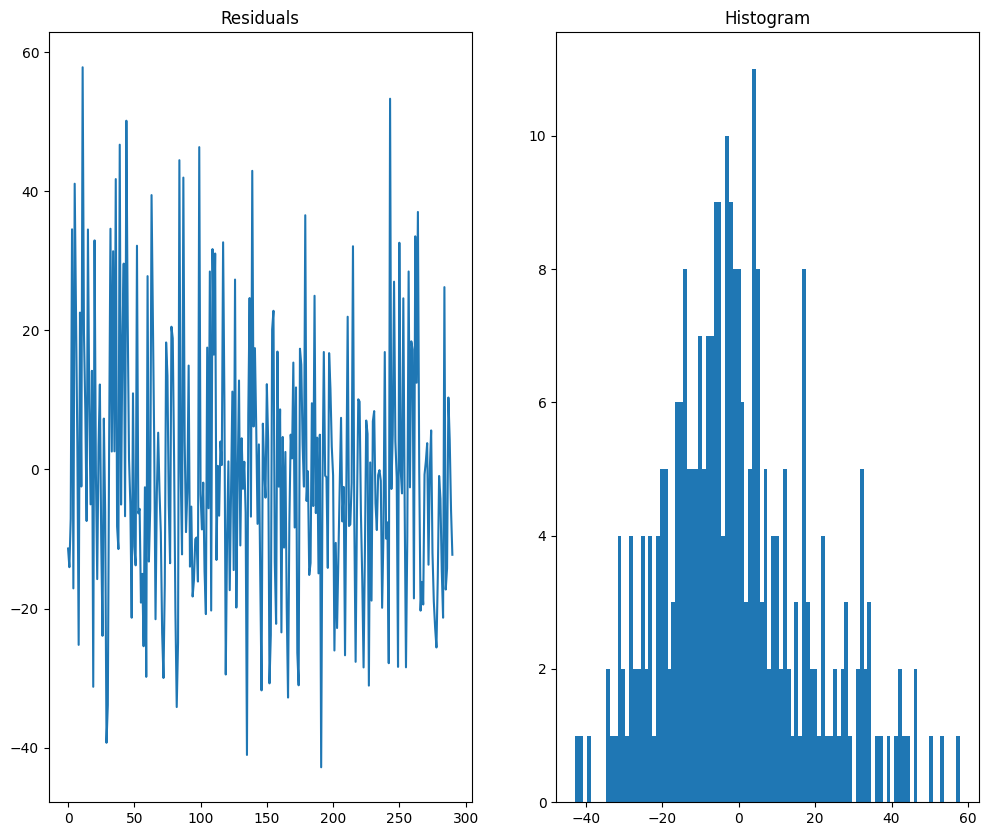

In [36]:
# Plot residuals
fig, axs = plt.subplots(1, 2,figsize=(12,10))
axs[0].plot(res.resid)
axs[0].set_title("Residuals")
axs[1].hist(res.resid,bins=100)
axs[1].set_title("Histogram")

# Test for whitness of residuals

# The Ljung-Box test is a statistical test that checks if autocorrelation exists in a time series.
# It uses the following hypotheses:
#   H0: The residuals are independently distributed.
#   HA: The residuals are not independently distributed; they exhibit serial correlation.
# Ideally, we would like to fail to reject the null hypothesis. That is, we would like to see the p-value of the test be greater than 0.05 because 
# this means the residuals for our time series model are independent, which is often an assumption we make when creating a model.
print("Ljung-Box and Box-Pierce for residual autocorrelation")
res_lb = sm.stats.diagnostic.acorr_ljungbox(res.resid, lags=10, boxpierce=True, model_df=1+0)
print(res_lb)

# Looking at the result of the Ljung-box test:
# The test statistic of the test is 8.285891 and the p-value of the test is 0.505612, which is greater than 0.05. 
# Thus, we accept the null hypothesis of the test and conclude that the residuals are independently distributed.


# Test for heteroscedasticity
# The null hypothesis is of no heteroskedasticity.
res_het = sm.tsa.stattools.breakvar_heteroskedasticity_test(res.resid, subset_length=1/3, alternative='two-sided')
print("Heteroscedasticity test results:")
print(f"P-val: {res_het[1]}")

# Since p-val is less than 0.05, we reject the null hypothesis, meaning there is heteroskedasticity in our data.
# To fix the issues of heteroskedasticity, I will take a cube root transformation of the response variable.

### Transform data to remove heteroscedasticity

In [37]:
# Transform data to remove heteroscedasticity
y_estimation_cbrt = np.cbrt(y_estimation)
y_test_cbrt = np.cbrt(y_test)

In [42]:
import warnings
warnings.filterwarnings("ignore") 

# Select appropraite ARIMA model
# estimate ICs
IC = sm.tsa.stattools.arma_order_select_ic(y_test_cbrt, max_ar=4, max_ma=4, ic=['aic','bic','hqic'], trend='c')

# display optimal lags
print(f"min AIC at (p,q): {IC.aic_min_order}")
print(f"min BIC at (p,q): {IC.bic_min_order}")
print(f"min HQIC at (p,q): {IC.hqic_min_order}")

min AIC at (p,q): (0, 1)
min BIC at (p,q): (0, 1)
min HQIC at (p,q): (0, 1)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  291
Model:                 ARIMA(2, 0, 3)   Log Likelihood                -643.036
Date:                Sun, 08 Jan 2023   AIC                           1300.072
Time:                        00:58:05   BIC                           1325.785
Sample:                             0   HQIC                          1310.373
                                - 291                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0629      0.052      1.213      0.225      -0.039       0.165
ar.L1         -0.6601      0.076     -8.649      0.000      -0.810      -0.510
ar.L2         -0.8933      0.077    -11.630      0.0

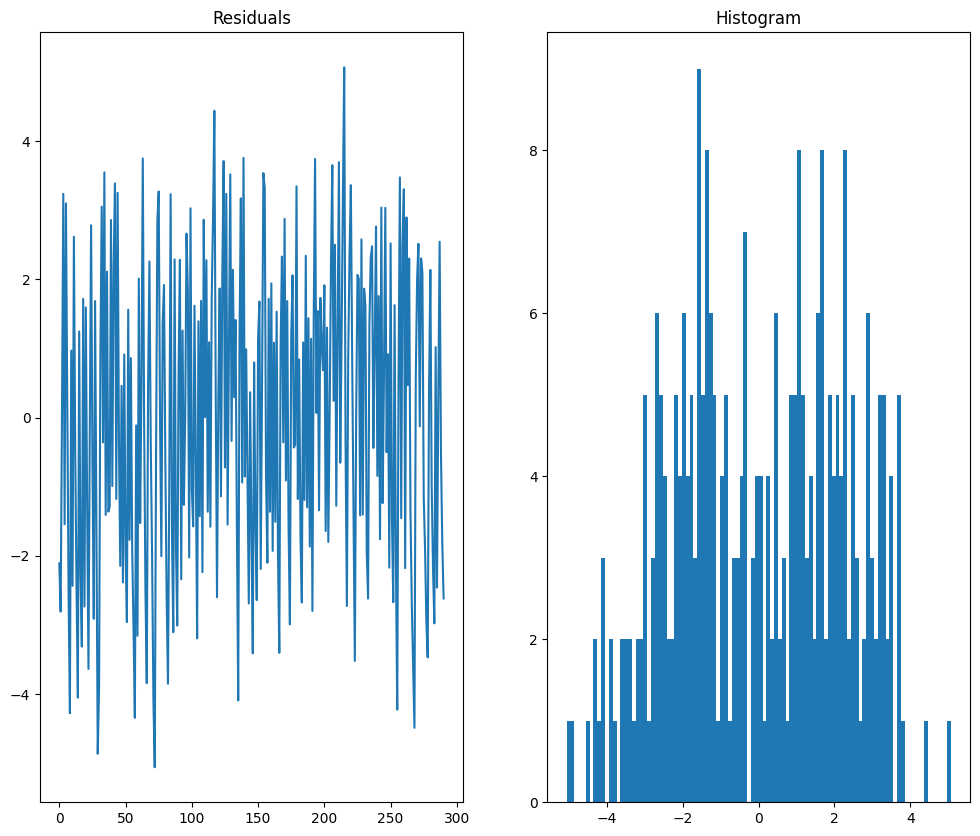

In [38]:
# Decide on ARIMA model using transformed data
mod = sm.tsa.arima.ARIMA(y_estimation_cbrt, order=(2, 0, 3), trend='c', validate_specification=True)
res = mod.fit()
print(res.summary())


# Plot residuals
fig, axs = plt.subplots(1, 2,figsize=(12,10))
axs[0].plot(res.resid)
axs[0].set_title("Residuals")
axs[1].hist(res.resid,bins=100)
axs[1].set_title("Histogram")

# Test for whitness of residuals 
print("Ljung-Box and Box-Pierce for residual autocorrelation")
res_lb = sm.stats.diagnostic.acorr_ljungbox(res.resid, lags=10, boxpierce=True,model_df=1+0)
print(res_lb)

# Test for heteroscedasticity
res_het = sm.tsa.stattools.breakvar_heteroskedasticity_test(res.resid, subset_length=1/3, alternative='two-sided')
print("Heteroscedasticity test results:")
print(f"P-val: {res_het[1]}")

# Since the p-value from the heteroscedasticity test is > than 0.05, we accept the null value that there is no heteroskedasticity.
# We notice our AIC, BIC, HQIC are now also lower. Means the model is much better than the previous.(ICs even suggest this model)
# const and ma.L1 are no longer statistically significant since theie p-values are > 0.05.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  291
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -645.560
Date:                Sun, 08 Jan 2023   AIC                           1297.120
Time:                        00:58:06   BIC                           1308.140
Sample:                             0   HQIC                          1301.534
                                - 291                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0633      0.053      1.194      0.232      -0.041       0.167
ma.L1         -0.6001      0.061     -9.816      0.000      -0.720      -0.480
sigma2         4.9403      0.662      7.465      0.0

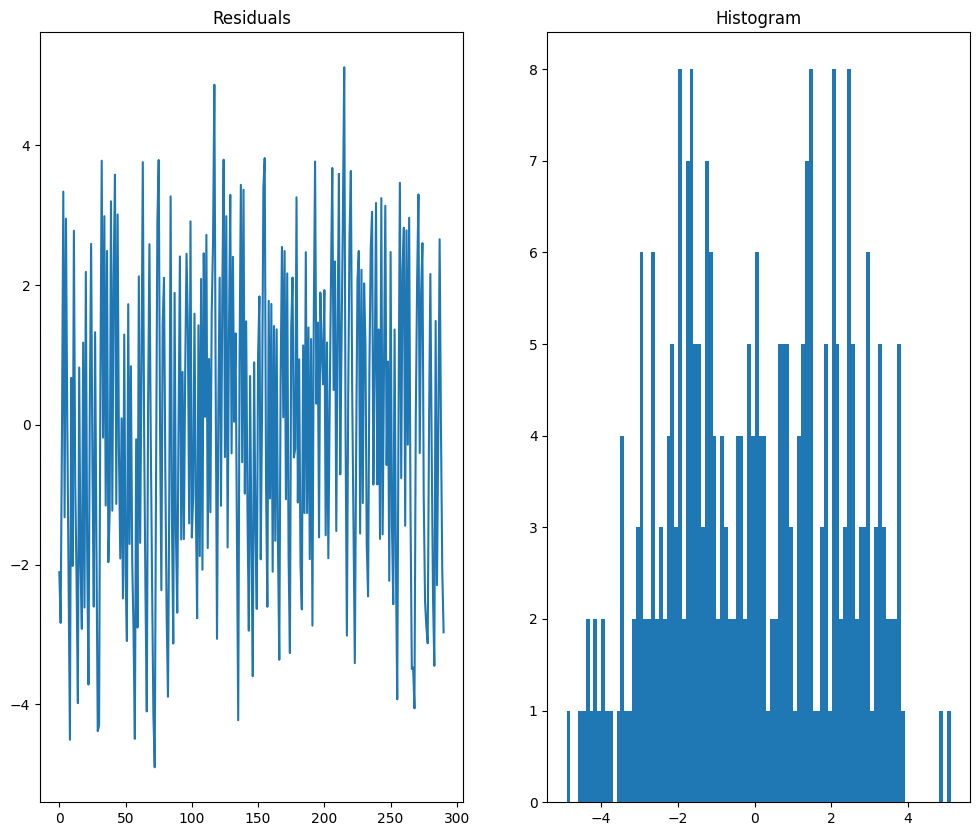

In [39]:
# Decide on ARIMA model using transformed data
mod = sm.tsa.arima.ARIMA(y_estimation_cbrt, order=(0, 0, 1), trend='c', validate_specification=True)
res = mod.fit()
print(res.summary())


# Plot residuals
fig, axs = plt.subplots(1, 2,figsize=(12,10))
axs[0].plot(res.resid)
axs[0].set_title("Residuals")
axs[1].hist(res.resid,bins=100)
axs[1].set_title("Histogram")

# Test for whitness of residuals 
print("Ljung-Box and Box-Pierce for residual autocorrelation")
res_lb = sm.stats.diagnostic.acorr_ljungbox(res.resid, lags=10, boxpierce=True,model_df=1+0)
print(res_lb)

# Test for heteroscedasticity
res_het = sm.tsa.stattools.breakvar_heteroskedasticity_test(res.resid, subset_length=1/3, alternative='two-sided')
print("Heteroscedasticity test results:")
print(f"P-val: {res_het[1]}")

# I will select the ARIMA(0, 0, 1) model since its AIC and BIC are slightly lower than that of ARIMA(2, 0, 3).
# A lower AIC and BIC indicates that the model fits the data well while also being relatively simple.

Use the model (from step 2) and perform 1-step-ahead forecasts for your series for the remaining 20% of the sample. Plot the forecasts and the true values. Report also RMSE of the forecasts.

predicted=1.845488, expected=-1.324882
predicted=1.921835, expected=-2.119680
predicted=2.368570, expected=2.871792
predicted=-0.232608, expected=-2.675356
predicted=1.454994, expected=-1.739464
predicted=1.855567, expected=2.554365
predicted=-0.348699, expected=-2.554365
predicted=1.299411, expected=-2.714418
predicted=2.289809, expected=3.851714
predicted=-0.834426, expected=-2.629536
predicted=1.053739, expected=2.924018
predicted=-1.022207, expected=1.304956
predicted=-1.282762, expected=1.632140
predicted=-1.599331, expected=1.277182
predicted=-1.547354, expected=-2.304898
predicted=0.470665, expected=-1.324882
predicted=1.058492, expected=3.433470
predicted=-1.290582, expected=-2.873594
predicted=0.943598, expected=2.496291
predicted=-0.829020, expected=-2.259692
predicted=0.860294, expected=-2.056367
predicted=1.697325, expected=-1.682391
predicted=1.928191, expected=0.000000
predicted=1.097202, expected=2.320794
predicted=-0.638310, expected=-2.811442
predicted=1.247461, expect

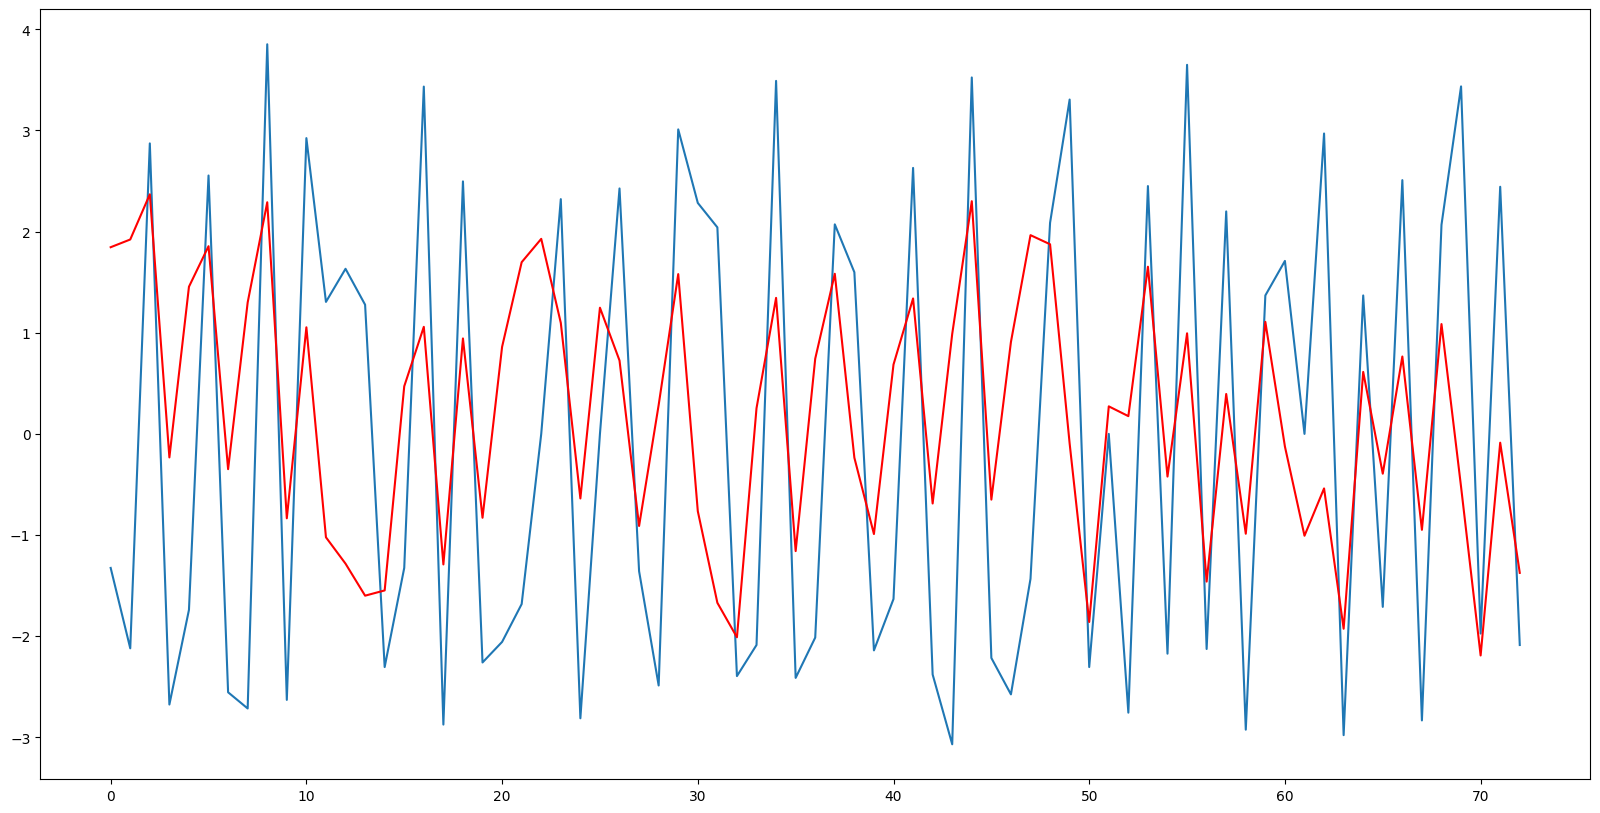

In [40]:
predictions = list()
history = [x for x in y_estimation_cbrt]

for t in range(len(y_test_cbrt)):
    model = sm.tsa.arima.ARIMA(history, order=(0, 0, 1), trend='c', validate_specification=True)
    model_fit = model.fit()
    output = model_fit.forecast() # one-step forecast
    yhat = output[0]
    predictions.append(yhat)
    obs = y_test_cbrt[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

# evaluate forecasts
rmse = sm.tools.eval_measures.rmse(y_test_cbrt, predictions)
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(nrows=1, ncols=1)

ax0 = fig.add_subplot(gs[0, :])
ax0.plot(y_test_cbrt)
ax0.plot(predictions, color='red')
plt.show()

predicted=12.871370, expected=-2.325581
predicted=13.701684, expected=-9.523810
predicted=19.384549, expected=23.684211
predicted=-0.437954, expected=-19.148936
predicted=16.096732, expected=-5.263158
predicted=17.841524, expected=16.666667
predicted=3.442878, expected=-16.666667
predicted=16.869028, expected=-20.000000
predicted=28.340345, expected=57.142857
predicted=-17.572130, expected=-18.181818
predicted=3.015953, expected=25.000000
predicted=-13.156533, expected=2.222222
predicted=-8.403601, expected=4.347826
predicted=-6.471194, expected=2.083333
predicted=-3.446527, expected=-12.244898
predicted=8.894945, expected=-2.325581
predicted=10.647161, expected=40.476190
predicted=-18.728446, expected=-23.728814
predicted=6.211927, expected=15.555556
predicted=-4.038469, expected=-11.538462
predicted=8.010252, expected=-8.695652
predicted=14.617089, expected=-4.761905
predicted=16.493120, expected=0.000000
predicted=14.336260, expected=12.500000
predicted=3.895588, expected=-22.222222

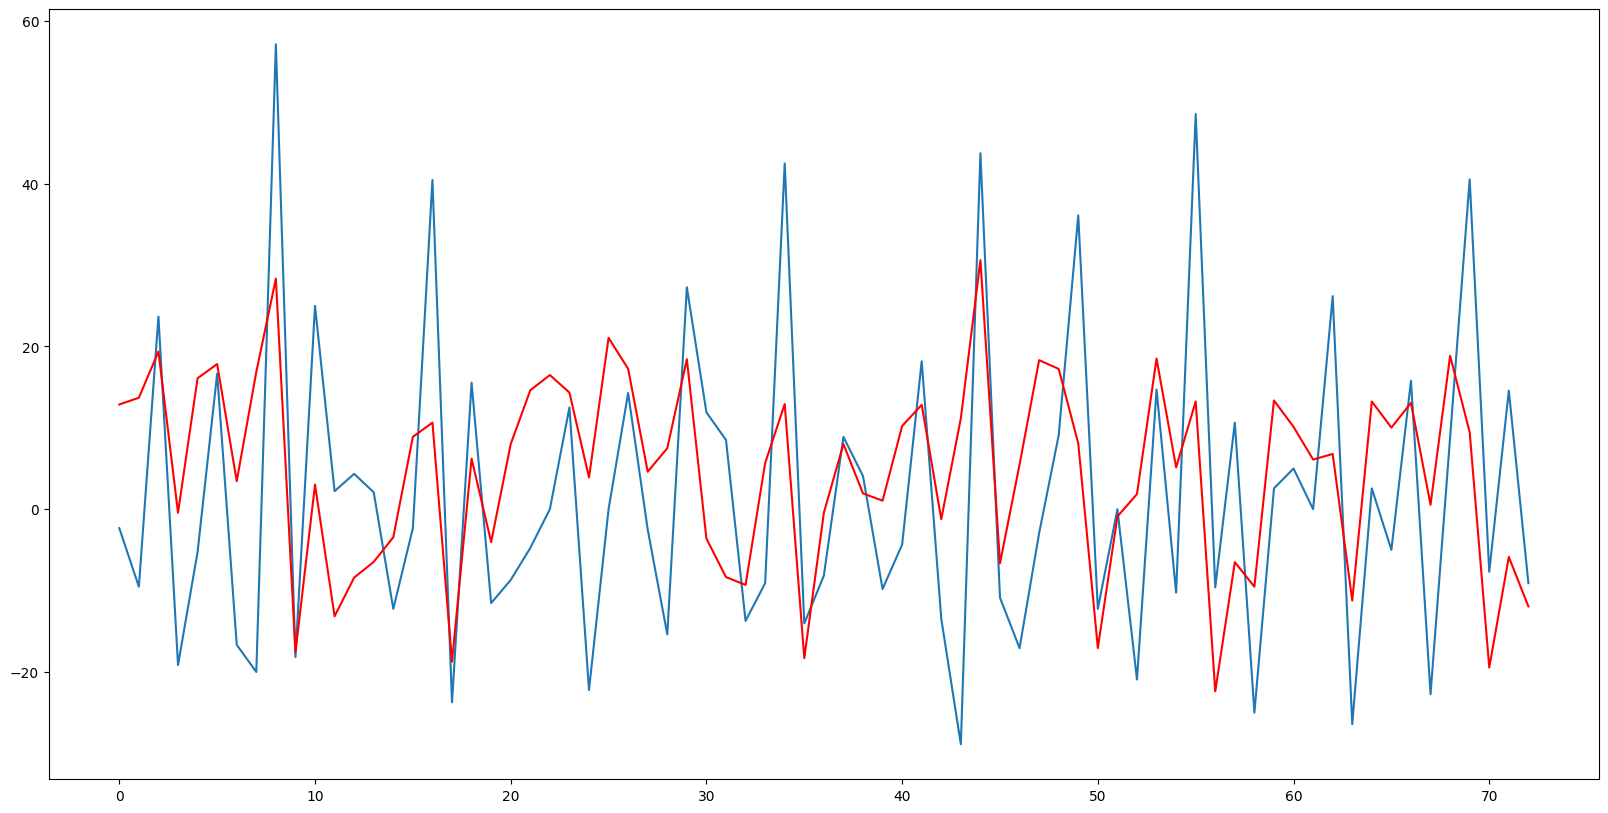

In [41]:
# Just for the sake of exploration, what would our model have look liked without removing heteroscedasticity
predictions = list()
history = [x for x in y_estimation]

for t in range(len(y_test)):
    model = sm.tsa.arima.ARIMA(history, order=(0, 0, 1), trend='c', validate_specification=True)
    model_fit = model.fit()
    output = model_fit.forecast() # one-step forecast
    yhat = output[0]
    predictions.append(yhat)
    obs = y_test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

# evaluate forecasts
rmse = sm.tools.eval_measures.rmse(y_test, predictions)
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(nrows=1, ncols=1)

ax0 = fig.add_subplot(gs[0, :])
ax0.plot(y_test)
ax0.plot(predictions, color='red')
plt.show()
# WITHOUT REMOVING HETEROSCEDASTICITY, OUR MODEL WOULD HAVE BEEN A LOT WORSE